In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [2]:
from skimage import io, filters, draw
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skimage.color import rgb2gray
from skimage import data
from skimage.morphology import disk
from skimage.filters import median
import os

In [3]:
def Trim_Outer_Circle(sky):
    # Trim out the extra black on the left and right side of the image
    x1_trim = 300
    x2_trim = 2280
    
    # Determine the dimensions of the image
    width = sky.shape[0]
    height = sky.shape[1]
    center_on_width = int(width / 2)
    center_on_height = int(height / 2)
    width, height, center_on_width, center_on_height
    circle_radius = 971
    
    # Trim the pixels around the sky
    sky_circle = np.zeros((width, height), dtype=np.uint8)
    rr, cc = draw.circle(center_on_width, center_on_height, circle_radius)
    sky_circle[rr, cc] = 1
    sky_trimmed = sky.copy()
    sky_trimmed[sky_circle == 0] = 0
    return sky_trimmed[:, x1_trim : x2_trim]
    
def Load_And_Trim(filename):
    sky = io.imread(filename)
    sky_trimmed = Trim_Outer_Circle(sky)
    return sky_trimmed


In [4]:
def Process_Image_Haze_Ratio(image_path):
    sky_trimmed = Load_And_Trim(image_path)
    haze_numerator = ((sky_trimmed[..., 0] + sky_trimmed[..., 2])/2) - sky_trimmed[..., 1]
    haze_denominator = ((sky_trimmed[..., 0] + sky_trimmed[..., 2])/2) + sky_trimmed[..., 1]
    haze_ratio = haze_numerator/haze_denominator
    
    
    return haze_ratio

C:\Users\Mihir Deshmukh\Documents\University\4.Senior Year\2.Winter Quarter\CPE461\Cloud-Prediction\Sky_Camera_Images\2018-11-22 09~20~00-07~00.jpg


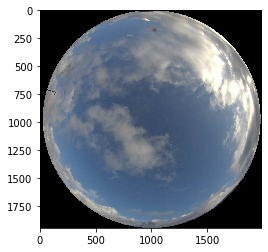

In [5]:
image_path = os.getcwd() +'\\Sky_Camera_Images\\' + '2018-11-22 09~20~00-07~00.jpg'
print(image_path)
trimmed = Load_And_Trim(image_path)
plt.imshow(trimmed)

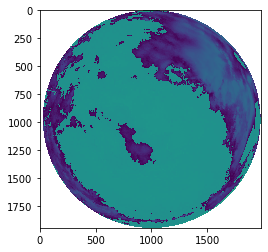

In [6]:
#Example of image with Haze filter applied
image_path = os.getcwd() +'\\Sky_Camera_Images\\' + '2018-11-22 09~20~00-07~00.jpg'
hazed_ratio = Process_Image_Haze_Ratio(image_path)
hazed_sky = rgb2gray(hazed_ratio)
plt.imshow(hazed_sky)

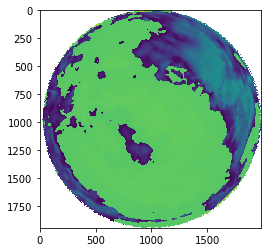

In [7]:
# Apply a median filter to image with haze filter
image_path = os.getcwd() +'\\Sky_Camera_Images\\' + '2018-11-22 09~20~00-07~00.jpg'
hazed_ratio = Process_Image_Haze_Ratio(image_path)
hazed_sky = median(hazed_ratio, disk(10))
plt.imshow(hazed_sky)


